# Import libraries

In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import colors
import h5py
import re
from typing import Optional
import datetime as dt

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_prim_quench_ee_plateau2 import RBFPAPrimQuenchEEPlateau2
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench
from src.utils.frequency_utils import *
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_NMF, plot_nmf_event_composition, plot_avg_component_weight, plot_distribution_over_column, plot_component_distribution, plot_cweight_distribution_all_data
from src.visualisation.visualisation import make_gif
from src.models.nmf import NMF
from src.utils.utils import pd_dict_filt, nanargsort, merge_array
from src.utils.sort_utils import map_position_index, center_array, split_main_mirror, calc_snr, main_mirror_to_el, generate_sorted_value_dict

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')


# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")#.drop_duplicates('fpa_identifier')
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['fpa_identifier'])
len(mp3_fpa_df), len(mp3_fpa_df_unique)

(3981, 822)

In [5]:
mp3_fpa_df_unique['I_Q_kA'] = mp3_fpa_df_unique["I_Q_M"].apply(lambda x: np.round(x / 1e3)*1e3)
mp3_fpa_df_unique['dI_dt_from_data_round'] = mp3_fpa_df_unique["dI_dt_from_data"].apply(lambda x: int(np.round(x)))

mp3_fpa_df_unique['datetime'] = pd.to_datetime(mp3_fpa_df_unique['Date (FGC)'])
mp3_fpa_df_unique['year'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.year)
mp3_fpa_df_unique['month'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.month)
mp3_fpa_df_unique['day'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.day)

# Read metadata

In [6]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,age,Manufacturer,Inner cable type,Outer cable type,I_Q_SM18,Renamed short magnet ID,MTF Status,Magnet_construction_order,QPS Crate Number,Cryostat Number
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,14.0,3.0,01B,02B8,11488.0,NaN,NaN,288,0,0
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,14.0,2.0,01E,02C0,10622.0,NaN,NaN,256,0,1
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,14.0,2.0,01E,02C9,12427.0,NaN,NaN,330,1,0
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,14.0,2.0,01E,02C9,11155.0,NaN,NaN,319,2,1
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,14.0,1.0,01E,02B8,11782.0,NaN,NaN,296,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,14.0,3.0,01B,02G,12645.0,NaN,NaN,123,1,1
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,14.0,1.0,01B,02B5,12379.0,NaN,NaN,62,1,0
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,14.0,2.0,01B,02K,11757.0,NaN,NaN,61,2,1
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,14.0,3.0,01B,02G,11656.0,NaN,NaN,172,0,0


In [7]:
mp3_fpa_df_unique = mp3_fpa_df_unique.merge(rb_magnet_metadata,
                                            left_on=["Magnet"],
                                            right_on=["Magnet"],
                                            how="left", suffixes=('', '_y'))

drop_columns = mp3_fpa_df_unique.filter(regex='Unnamed').columns.to_list()
drop_columns += mp3_fpa_df_unique.filter(regex='_y').columns.to_list()
mp3_fpa_df_unique = mp3_fpa_df_unique.drop(columns=drop_columns)

# Read position map

In [8]:
pos_map_path = Path("../data/circuit_sort.csv")
df_pos_map = pd.read_csv(pos_map_path)

In [9]:
df_pos_map_subset = df_pos_map[(df_pos_map["Circuit"] == 'RB.A12') & (df_pos_map["El. Quench Position"] == 0)].reset_index(drop=True)
value_columns = df_pos_map_subset.filter(regex= ". ").columns
df_pos_map_subset[value_columns] = (df_pos_map_subset[value_columns] +1)
df_pos_map_subset.T

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
Circuit,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,...,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12
Magnet,MB.A8L2,MB.A9L2,MB.A10L2,MB.A11L2,MB.A12L2,MB.C12L2,MB.B13L2,MB.A14L2,MB.C14L2,MB.B15L2,...,MB.C15L2,MB.A15L2,MB.B14L2,MB.C13L2,MB.A13L2,MB.B12L2,MB.B11L2,MB.B10L2,MB.B9L2,MB.B8L2
El. Position,1,2,3,4,5,6,7,8,9,10,...,145,146,147,148,149,150,151,152,153,154
Phys. Position,154,152,150,148,146,144,142,140,138,136,...,135,137,139,141,143,145,147,149,151,153
Phys. Dist. to PC,1,3,5,7,9,11,13,15,17,19,...,20,18,16,14,12,10,8,6,4,2
Phys. Position ODD,154,152,150,148,146,144,142,140,138,136,...,135,137,139,141,143,145,147,149,151,153
Phys. Position EVEN,2,4,6,8,10,12,14,16,18,20,...,19,17,15,13,11,9,7,5,3,1
El. Quench Position,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Phys. Quench Position,154,154,154,154,154,154,154,154,154,154,...,154,154,154,154,154,154,154,154,154,154
Phys. Dist. to Quench,155,153,151,149,147,145,143,141,139,137,...,136,138,140,142,144,146,148,150,152,154


In [10]:
df_pos_map = df_pos_map.set_index(['Circuit', 'El. Quench Position', 'Phys. Quench Position']) # allows faster indexing

# Load Data

In [11]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
dataset_path_2EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_RBFPAPrimQuenchEEPlateau2")

all_fpa_identifiers = mp3_fpa_df.fpa_identifier.unique()

dataset_creator = RBFPAPrimQuenchEEPlateau()
dataset = dataset_creator.load_dataset(fpa_identifiers=all_fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])

In [12]:
# postprocess timeseries data
dataset_detrend = dataset_creator.detrend_dim(dataset)

# calculate fft
f_window = np.hamming
f_lim = (0, 360)
dataarray_fft = get_fft_of_DataArray(data=dataset_detrend.data, f_window=f_window, f_lim=f_lim)
dataarray_fft_amplitude = scale_fft_amplitude(data=dataarray_fft, f_window=f_window)
dataarray_fft_amplitude = dataarray_fft_amplitude[:, :, dataarray_fft_amplitude.frequency < f_lim[1]]

In [14]:
lower_bound = 1e-3
upper_bound = 1
data_scaled = np.array([dataset_creator.log_scale_data(x, vmin=lower_bound, vmax=upper_bound)
                        for x in dataarray_fft_amplitude.data])

data_processed = np.nan_to_num(data_scaled.reshape(-1, np.shape(data_scaled)[2]))

## Define training data

In [15]:
# model is not trained on data before 2021 and events with fast secondary quenches
test_conditions = ((mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 < 5) &
                   (mp3_fpa_df['Nr in Q event'].astype(str) != '1'))|\
                  (mp3_fpa_df['timestamp_fgc'] < 1611836512820000000)
bool_test = np.isin(dataset.event.values, mp3_fpa_df[test_conditions].fpa_identifier.unique())

fpa_identifiers_train = dataset.event.values[~bool_test]
fpa_identifiers_test = dataset.event.values[bool_test]

# add dims for indexing flattended data
bool_train_flattened = np.stack([~bool_test for l in range(data_scaled.shape[1])]).T.reshape(-1)

print(len(fpa_identifiers_train), len(fpa_identifiers_test))

425 135


# <h1><center><font size="30">Non-negative components - NMF</font></center></h1>

<h1><font size="8">1st Energy Extraction Plateau</font></h1>

<AxesSubplot:xlabel='Unnamed: 0'>

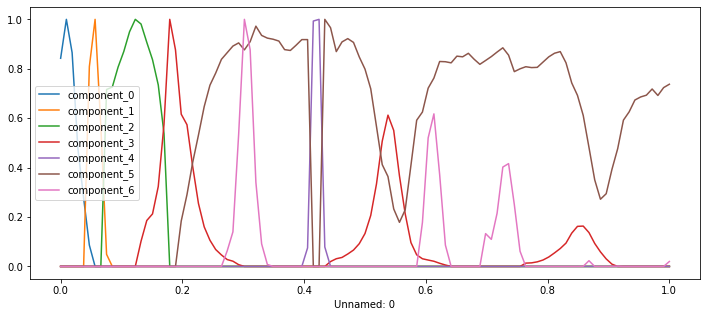

In [31]:
df_components = pd.read_csv("../output/components_adjusted.csv")

df_components = df_components / df_components.max(axis=0)
df_components.plot(x="Unnamed: 0", figsize = (12,5))

In [38]:
data_processed[bool_train_flattened].shape

(65450, 149)

In [39]:
df_components.values[:,1:-1].T.shape

(6, 107)

In [33]:
hyperparameter = {
    "n_components": 6,
    "solver": "mu",
    "beta_loss": 'frobenius',
    "init": "nndsvd",
    "tol": 1e-5,
    "max_iter": 200,
    "l1_ratio": 0.5,
    "alpha": 0,
    "shuffle": "False",
    "ortho_reg": 0 
}
nmf_model = NMF(**hyperparameter)
nmf_model.fit(X=data_processed[bool_train_flattened], H=df_components.values[:,1:-1].T, not_init_H_idx=True)
W_1EE = nmf_model.transform(X=data_processed)
H_1EE = nmf_model.components_

plot_nmf_components(H_1EE, dataarray_fft_amplitude, hyperparameters=hyperparameter, norm_component=False)

np.linalg.norm(data_processed - W_1EE @ H_1EE)

ValueError: shape mismatch: value array of shape (1,6,107) could not be broadcast to indexing result of shape (1,6,149)

# Refit components

32.69202674179729

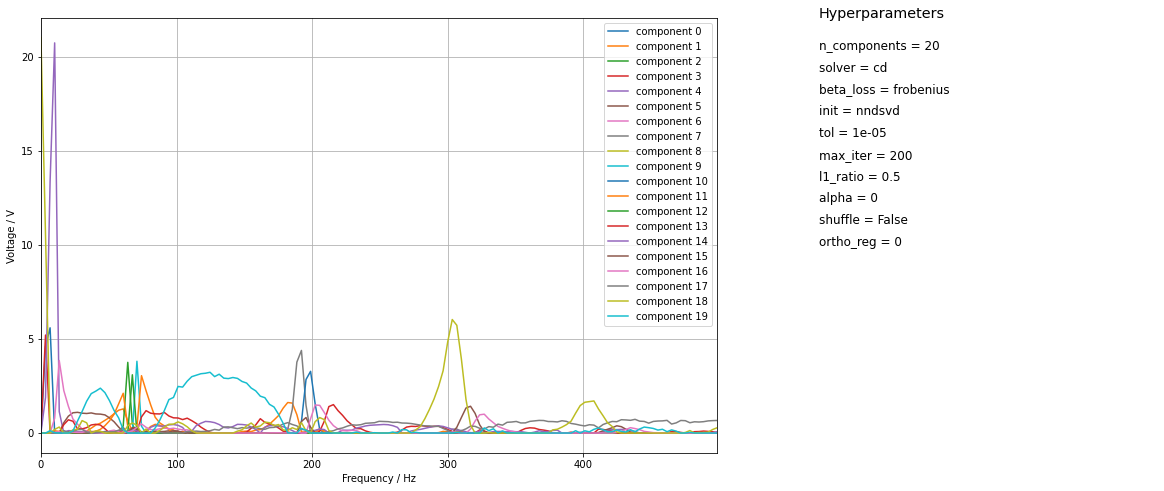

In [17]:
hyperparameter = {
    "n_components": 20,
    "solver": "cd",
    "beta_loss": 'frobenius',
    "init": "nndsvd",
    "tol": 1e-5,
    "max_iter": 200,
    "l1_ratio": 0.5,
    "alpha": 0,
    "shuffle": "False",
    "ortho_reg": 0 
}
nmf_model = NMF(**hyperparameter)
nmf_model.fit(X=data_processed[bool_train_flattened])
W_1EE = nmf_model.transform(X=data_processed)
H_1EE = nmf_model.components_

plot_nmf_components(H_1EE, dataarray_fft_amplitude, hyperparameters=hyperparameter, norm_component=False)

np.linalg.norm(data_processed - W_1EE @ H_1EE)

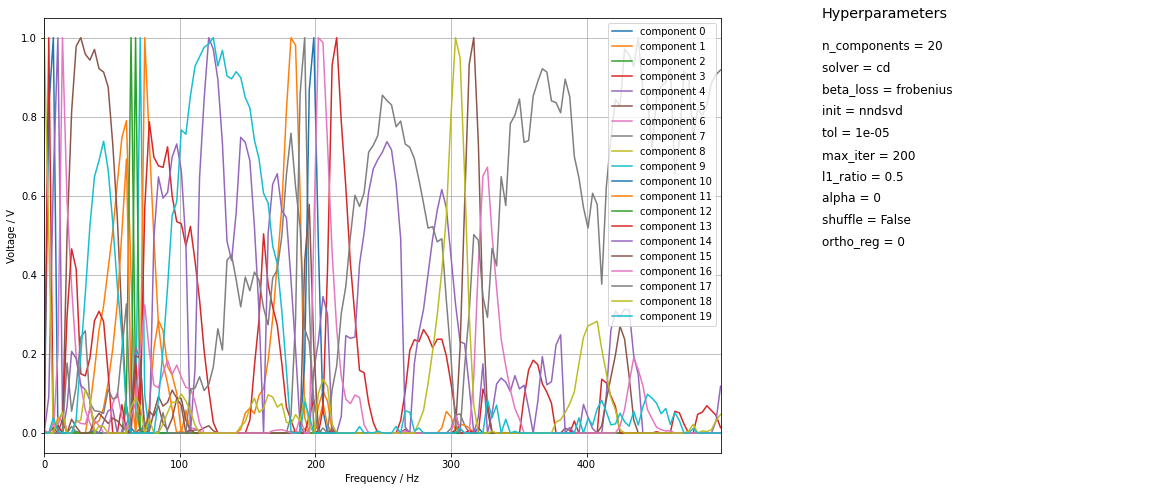

In [18]:
H_1EE_processed, W_1EE_processed = nmf_model.normalize_H(H=H_1EE, W=W_1EE)

plot_nmf_components(H_1EE_processed, dataarray_fft_amplitude, hyperparameters=hyperparameter, norm_component=False)

# Check components

In [19]:
use_fpa_identifier = True
if use_fpa_identifier:
    # provide fpa_identifier
    fpa_identifier = 'RB_RB.A78_1617170255140000000'
    event_idex = np.argmax(fpa_identifiers == fpa_identifier)
else: 
    # provide event_index 
    event_idex = 1 #30
    dataset_fft_cut = dataset_1EE_fft.loc[{'event': fpa_identifiers}]
    fpa_identifier =  dataset_fft_cut[{'event': event_idex}].event.values

date = mp3_fpa_df[mp3_fpa_df.fpa_identifier == fpa_identifier]['Timestamp_PIC'].values[0]
event_idex, fpa_identifier, date

NameError: name 'fpa_identifiers' is not defined

In [ ]:
component_indexes_1EE = [0, 1, 2, 3, 4, 5] 
plot_nmf_event_composition(data_processed, W_1EE_processed, H_1EE_processed, component_indexes_1EE, dataarray_fft_amplitude, fpa_identifier, mp3_fpa_df, vmin=lower_bound, vmax=upper_bound)

# Reconstruct time series

In [25]:
dataarray_preprocessed = dataset_detrend.data * f_window(len(dataset_detrend.time))

In [26]:
# reconstruct fft without NMF
dataset_ifft = get_ifft_of_DataArray(data=dataarray_fft, start_time=dataset.time.values[0])
dataset_win = dataset_ifft / f_window(len(dataset_ifft.time))

# add trend back
dataset_frec = xr.apply_ufunc(np.real, dataset_win).to_dataset()
dataset_frec["polyfit_coefficients"] = dataset_detrend.polyfit_coefficients
dataset_frec = dataset_creator.trend_dim(dataset_frec)

In [27]:
# reconstruct fft with NMF
rec_amplitude = (W_1EE_processed @ H_1EE_processed).reshape(data_scaled.shape)
rec_amplitude_unscaled = dataset_creator.exp_scale_data(rec_amplitude, vmin=lower_bound, vmax=upper_bound)

dataarray_fft_amplitude_rec = xr.zeros_like(dataarray_fft, dtype=float)

dataarray_fft_amplitude_rec[:,:,:rec_amplitude.shape[-1]] = rec_amplitude_unscaled

# assemble reconstructed fft
dataarray_fft_real= scale_fft_amplitude(data=dataarray_fft_amplitude_rec, f_window=f_window, is_polar=True)
_ , dataarray_fft_phase = complex_to_polar(dataarray_fft)
dataset_fft_rec = polar_to_complex(dataarray_fft_real, dataarray_fft_phase)

# ifft of reconstruction
dataset_ifft_rec = get_ifft_of_DataArray(data=dataset_fft_rec, start_time=dataset.time.values[0])
dataset_rec_win = dataset_ifft_rec / f_window(len(dataset_ifft_rec.time))

# add trend back
dataset_rec = xr.apply_ufunc(np.real, dataset_rec_win).to_dataset()
dataset_rec["polyfit_coefficients"] = dataset_detrend.polyfit_coefficients
dataset_rec = dataset_creator.trend_dim(dataset_rec)

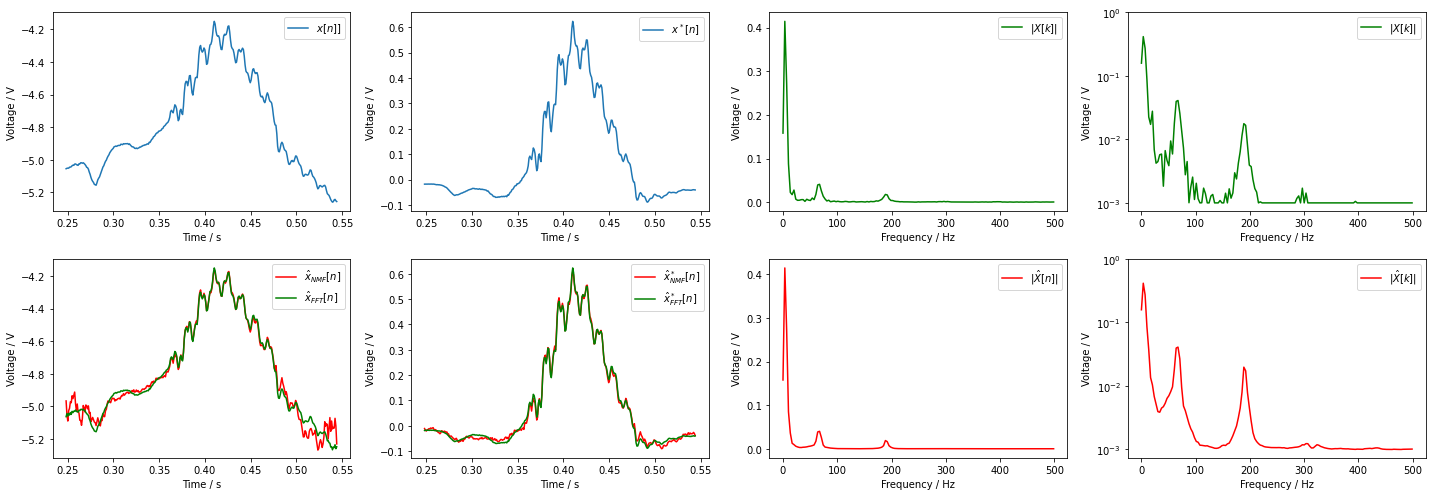

In [28]:
event=2
magnet=150
vdiff = np.log10(upper_bound) - np.log10(lower_bound)
n_ticks = int(vdiff) + 1

fig, ax = plt.subplots(2,4, figsize =(20,7))

# x(t)
ax[0, 0].plot(dataset.time, dataset.data[event, magnet].T)
ax[0, 0].set_xlabel('Time / s')
ax[0, 0].set_ylabel('Voltage / V')
ax[0, 0].legend(['$x[n]]$'])

# x*(t)
ax[0, 1].plot(dataset.time, dataarray_preprocessed.data[event, magnet].T)
ax[0, 1].set_xlabel('Time / s')
ax[0, 1].set_ylabel('Voltage / V')
ax[0, 1].legend(['$x^*[n]$'])

# X(k)
ax[0, 2].plot(dataarray_fft_amplitude.frequency, dataarray_fft_amplitude[event, magnet].T, c="g")
ax[0, 2].set_xlabel('Frequency / Hz')
ax[0, 2].set_ylabel('Voltage / V')
ax[0, 2].legend(['$|X[k]|$'])

# X(k) log
ax[0, 3].plot(dataarray_fft_amplitude.frequency, data_scaled[event, magnet].T, c="g")
ax[0, 3].set_xlabel('Frequency / Hz')
ax[0, 3].set_ylabel('Voltage / V')
ax[0, 3].set_yticks(np.linspace(0, 1, n_ticks))
ax[0, 3].set_yticklabels([f"$10^{{{int(np.log10(lower_bound)) + a}}}$" for a in range(n_ticks)])
ax[0, 3].legend(['$|X[k]|$'])

# WH log
ax[1, 3].plot(dataarray_fft_amplitude.frequency, rec_amplitude[event, magnet].T, c="r")
ax[1, 3].set_xlabel('Frequency / Hz')
ax[1, 3].set_ylabel('Voltage / V')
ax[1, 3].set_yticks(np.linspace(0, 1, n_ticks))
ax[1, 3].set_yticklabels([f"$10^{{{int(np.log10(lower_bound)) + a}}}$" for a in range(n_ticks)])
ax[1, 3].legend(['$|\hat{X}[k]|$'])

# WH
ax[1, 2].plot(dataarray_fft_amplitude.frequency, rec_amplitude_unscaled[event, magnet].T, c="r")
ax[1, 2].set_xlabel('Frequency / Hz')
ax[1, 2].set_ylabel('Voltage / V')
ax[1, 2].legend(['$|\hat{X}[n]|$'])

# \hat{x}*(t)
ax[1, 1].plot(dataset.time, dataset_ifft_rec[event, magnet].T, c="r")
ax[1, 1].plot(dataset.time, dataset_ifft[event, magnet].T, c="g")
ax[1, 1].set_xlabel('Time / s')
ax[1, 1].set_ylabel('Voltage / V')
ax[1, 1].legend(['$\hat{x}^*_{NMF}[n]$', '$\hat{x}^*_{FFT}[n]$'])

# \hat{x}(t)
ax[1, 0].plot(dataset.time, dataset_rec.data[event, magnet].T, c="r")
ax[1, 0].plot(dataset.time, dataset_frec.data[event, magnet].T, c="g")
ax[1, 0].set_xlabel('Time / s')
ax[1, 0].set_ylabel('Voltage / V')
ax[1, 0].legend(['$\hat{x}_{NMF}[n]$', '$\hat{x}_{FFT}[n]$'])
ax[1, 0].set_ylim(ax[0, 0].get_ylim())

plt.tight_layout()

# Reconstruct components

In [29]:
def plot_components_timeseries(ax, components, ylim, event=2, magnet=150):
    
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    c = []
    for i, component in enumerate(components):

        rec_amplitude_unscaled = dataset_creator.exp_scale_data(component * W_reshaped[event, magnet, i], vmin=lower_bound, vmax=upper_bound)

        dataarray_fft_amplitude_rec = xr.zeros_like(dataarray_fft[event, magnet], dtype=float)
        dataarray_fft_amplitude_rec[:rec_amplitude.shape[-1]] = rec_amplitude_unscaled

        # assemble reconstructed fft
        dataarray_fft_real= scale_fft_amplitude(data=dataarray_fft_amplitude_rec, is_polar=True)
        _ , dataarray_fft_phase = complex_to_polar(dataarray_fft[event, magnet])
        dataset_fft_rec = polar_to_complex(dataarray_fft_real, dataarray_fft_phase)

        # ifft of reconstruction
        dataset_ifft_rec = get_ifft_of_DataArray(data=dataset_fft_rec, start_time=dataset.time.values[0])
        #dataset_rec_win = dataset_ifft_rec * f_window(len(dataset_ifft_rec.time))

        ax[i, 0].plot(dataarray_fft_amplitude_rec.frequency, dataarray_fft_amplitude_rec, c=default_colors[i])
        ax[i, 0].set_xlabel('Frequency / Hz')
        ax[i, 0].set_ylabel('Voltage / V')
        ax[i, 0].set_xlim(0,dataarray_fft_amplitude_rec.frequency[rec_amplitude.shape[-1]]-1)
        ax[i, 0].set_ylim(ylim)
        
        ax[i, 1].plot(dataset_rec_win.time, dataset_ifft_rec.data, label=f'Component {i}', c=default_colors[i])
        ax[i, 1].set_xlabel('Time / s')
        ax[i, 1].set_ylabel('Voltage / V')
        ax[i, 1].set_ylim(ylim)
        
        #c.append(dataset_rec_win.data)
    #plt.plot(np.sum(c, axis=0))

IndexError: list index out of range

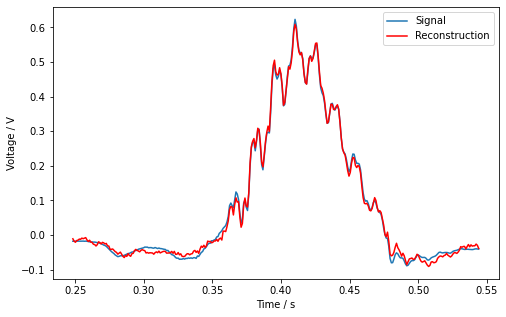

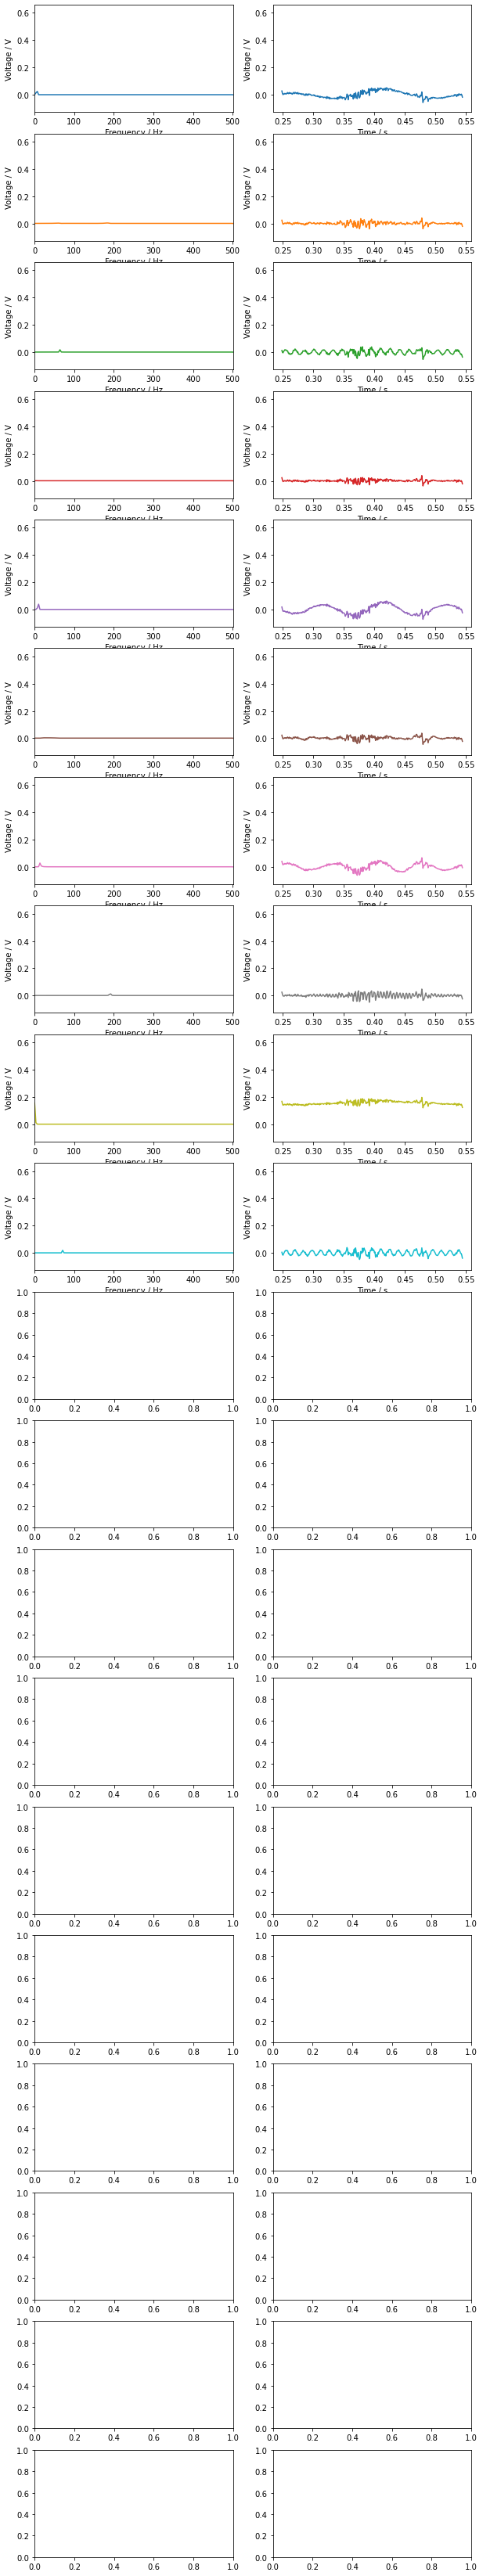

In [30]:
W_reshaped = W_1EE_processed.reshape(data_scaled.shape[:-1] + (-1, ))

fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(dataset.time, dataarray_preprocessed.data[event, magnet], label='Signal')
ax1.plot(dataset.time, dataset_ifft_rec.data[event, magnet].T, c="r", label='Reconstructed Signal')
ax1.set_xlabel('Time / s')
ax1.set_ylabel('Voltage / V')
ax1.legend(['Signal', 'Reconstruction'])

fig, ax = plt.subplots(len(H_1EE_processed) ,2, figsize=(10, 3*len(H_1EE_processed)))
plot_components_timeseries(ax, H_1EE_processed, ylim=ax1.get_ylim())  
plt.legend()
plt.tight_layout()

#plt.ylim([-1,1])

# Loss

In [ ]:
N = len(dataset_detrend.time.values)
dataset_processed = dataset_detrend.data.values * f_window(N)

fft_loss_sample = dataset_processed - np.real(dataset_ifft).values
nmf_loss_sample = dataset_processed - np.real(dataset_ifft_rec).values
nmf_loss_freq = data_scaled - (W_1EE_processed @ H_1EE_processed).reshape(data_scaled.shape)

fft_loss = np.linalg.norm(np.nan_to_num(fft_loss_sample), axis=2).max(axis=1).reshape(-1)
nmf_loss = np.linalg.norm(np.nan_to_num(nmf_loss_sample), axis=2).max(axis=1).reshape(-1)
nmf_loss_freq = np.linalg.norm(np.nan_to_num(nmf_loss_freq), axis=2).max(axis=1).reshape(-1)

#fft_outlier_idx = np.argsort(np.abs(fft_loss[~bool_test]))
#nmf_outlier_idx = np.argsort(np.abs(nmf_loss[~bool_test]))

outlier_events = ["RB_RB.A78_1619330143440000000",
                  "RB_RB.A12_1621014819920000000",
                  "RB_RB.A45_1620797547820000000"]  # "RB_RB.A34_1620105483360000000"

bool_outlier = np.isin(dataset.event.values, outlier_events)
# add dims for indexing flattended data
bool_outlier_flattened = np.stack([bool_outlier for l in range(data_scaled.shape[1])]).T.reshape(-1)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(np.abs(fft_loss[~bool_test]), np.abs(nmf_loss[~bool_test]), ".")
#plt.plot(np.abs(fft_loss[~bool_train]), np.abs(nmf_loss[~bool_train]), ".")
plt.plot(np.abs(fft_loss[bool_outlier]), np.abs(nmf_loss[bool_outlier]), ".")

plt.ylabel("$|||X[k]| -|\hat{X}[k]|$", fontsize=15)
plt.xlabel("$||x^*[n] - \hat{x}_{FFT}^*[n]||$", fontsize=15)

#plt.yscale("log")
#plt.xscale("log")

# Chi Squared test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Generate data from a gamma distribution
shape, scale = 2., 2.  # mean=4, std=2*sqrt(2)
data = gamma.rvs(shape, scale, size=1000)

# Plot the histogram of the data
plt.hist(data, bins=30, density=True, alpha=0.6, color='b')

# Fit a gamma distribution to the data
params_fit = gamma.fit(data)

# Plot the pdf of the fitted gamma distribution
x = np.linspace(0, 15, 1000)
pdf = gamma.pdf(x, *params_fit)
plt.plot(x, pdf, 'k--', lw=2)

upper = gamma.ppf(0.99, *params_fit)
plt.axvline(upper, c = 'red')

# Add a legend and display the plot
plt.legend(['Fitted Gamma Dist.', 'Data', '95% Confidence Interval'])
plt.show()

gamma.pdf(12, *params_fit)

In [ ]:
params_fit

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Generate data from a chi-squared distribution
#df = 5  # degrees of freedom
#data = chi2.rvs(df, size=1000)

data = nmf_loss[~bool_test]

# Fit a chi-squared distribution to the data
params_fit = chi2.fit(data)

# Plot the histogram of the data
plt.hist(data, bins=200, density=True, alpha=0.5, label='Data histogram')

# Plot the probability density function (pdf) of the fitted chi-squared distribution
x = np.linspace(0, data.max(), 100)
pdf = chi2.pdf(x, *params_fit)
plt.plot(x, pdf, label='Fitted chi-squared pdf')

# Add a legend to the plot
plt.legend()

upper = chi2.ppf(0.99, *params_fit)
plt.axvline(upper, c='red')

# Display the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

data = nmf_loss[~bool_test]

# Plot the histogram of the data
plt.hist(data, bins=300, density=True, alpha=0.6, color='b')

# Fit a gamma distribution to the data
params_fit = gamma.fit(data)

# Plot the pdf of the fitted gamma distribution
x = np.linspace(0, 3, 1000)
pdf = gamma.pdf(x, *params_fit)
plt.plot(x, pdf, 'k--', lw=2)

upper = gamma.ppf(0.99, *params_fit)
plt.axvline(upper, c = 'red')

# Add a legend and display the plot
plt.legend(['Fitted Gamma Dist.', 'Data', '95% Confidence Interval'])

plt.show()

gamma.pdf(12, *params_fit)

In [ ]:


data = nmf_loss[~bool_test]

var = np.var(data)
df = sum(~bool_test) - 1
X2 = chi2.isf(q=0.01, df=df)
var_threshold = data.std() *3#var * df / X2 

plt.hist(data, bins =300)
plt.axvline(var_threshold, c = 'red')
plt.yscale("log")
#plt.xscale("log")
for line in nmf_loss[bool_outlier]:
    plt.axvline(line, c = 'orange')
print(var, var_threshold)

plt.show()

# Plot Outliers

In [ ]:
n_plots = 5
fig, ax = plt.subplots(n_plots, 2, figsize =(12,4*n_plots))
for i, idx in enumerate(fft_outlier_idx[::-1][:n_plots]):
    ax[i, 0].plot(dataset.time, dataset.data[bool_train][idx].T)
    ax[i, 0].grid()
    ax[i, 0].set_xlabel('Time / s')
    ax[i, 0].set_ylabel('Voltage / V')
    ax[i, 0].set_title('$x[n]$')

    ax[i, 1].plot(dataset_detrend.time, np.real(dataset_frec.data[bool_train][idx].T))
    ax[i, 1].set_ylim(ax[i, 0].get_ylim())
    ax[i, 1].grid()
    ax[i, 1].set_xlabel('Time / s')
    ax[i, 1].set_ylabel('Voltage / V')
    ax[i, 1].set_title('$\hat{x}_{FFT}[n]$')
    ax[i, 1].legend([f'FFT Loss: {fft_loss[bool_train][idx]:.2f}'])
    
    plt.tight_layout()

In [ ]:
n_plots = 5
fig, ax = plt.subplots(n_plots, 2, figsize =(12,4*n_plots))
for i, idx in enumerate(nmf_outlier_idx[::-1][:n_plots]):
    ax[i, 0].plot(dataset.time, dataset.data[bool_train][idx].T)
    ax[i, 0].grid()
    ax[i, 0].set_xlabel('Time / s')
    ax[i, 0].set_ylabel('Voltage / V')
    ax[i, 0].set_title('$x[n]$')

    ax[i, 1].plot(dataset_detrend.time, np.real(dataset_rec.data[bool_train][idx].T))
    ax[i, 1].set_ylim(ax[i, 0].get_ylim())
    ax[i, 1].grid()
    ax[i, 1].set_xlabel('Time / s')
    ax[i, 1].set_ylabel('Voltage / V')
    ax[i, 1].set_title('$\hat{x}_{NMF}[n]$')
    ax[i, 1].legend([f'NMF Loss: {nmf_loss[bool_train][idx]:.2f}'])
    
    plt.tight_layout()